# Анализ подписки

`events_train.csv` - данные о действиях, которые совершают студенты со стэпами
- step_id - id стэпа
- user_id - анонимизированный id юзера
- timestamp - время наступления события в формате unix date
- action - событие, возможные значения: 
- discovered - пользователь перешел на стэп
- viewed - просмотр шага,
- started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
- passed - удачное решение практического шага

`submissions_train.csv` - данные о времени и статусах сабмитов к практическим заданиям
- step_id - id стэпа
- timestamp - время отправки решения в формате unix date
- submission_status - статус решения
- user_id - анонимизированный id юзера

In [178]:
import pandas as pd
import numpy as np
import ast

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

In [179]:
sns.set(rc={'figure.figsize': (9,6)})

In [180]:
submissions_data = pd.read_csv('resources/submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [181]:
events_data = pd.read_csv('resources/event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [182]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [183]:
period_of_course = events_data.date.max() - events_data.date.min() 
period_of_course

Timedelta('1069 days 19:32:43')

In [184]:
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<Axes: xlabel='day'>

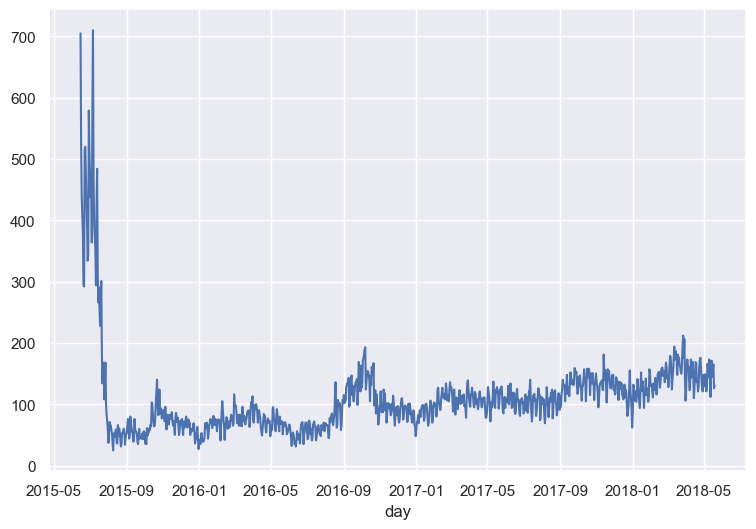

In [185]:
events_data.groupby('day') \
  .user_id.nunique().plot()

**Задача**: Сколько и каких пользователей с какими балами, сначала напишем неправильно и типичное решение, потом будет правильное

<Axes: >

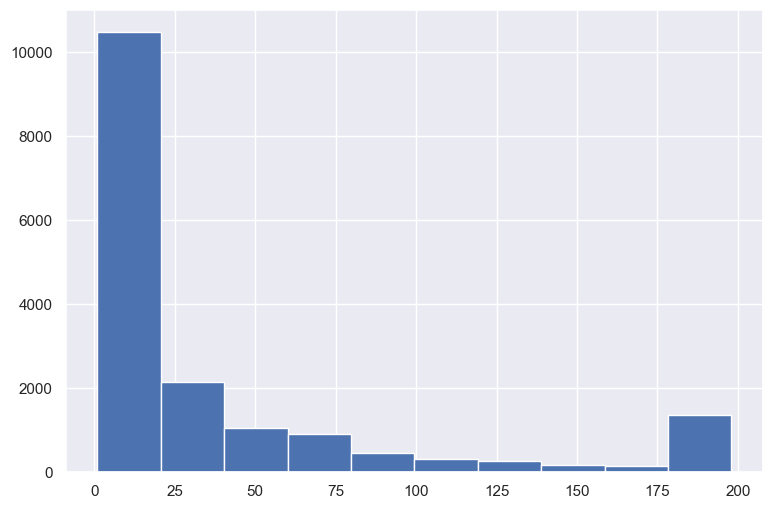

In [186]:
events_data[events_data.action == 'passed'] \
  .groupby('user_id', as_index=False) \
  .agg({'step_id': 'count'}) \
  .rename(columns={'step_id': 'passed_step'}).passed_step.hist()

Показывает что много пользователей который не дошли до конца. Мы потеряли много информации, так как есть пользователи у которых не оказалось события `passed`

In [187]:
events_data.pivot_table(index='user_id', columns='action',  values='step_id', aggfunc='count', fill_value=0).reset_index().head()
# index='user_id': Строки таблицы — уникальные идентификаторы пользователей.
# columns='action': Столбцы таблицы — уникальные действия, которые пользователи могут выполнять.
# values='step_id': Значение для агрегации — количество шагов (или событий) для каждой комбинации пользователь-действие.
# aggfunc='count': Функция агрегации — подсчет количества ненулевых значений.
# fill_value=0: Заменяет отсутствующие значения на 0.

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<Axes: >

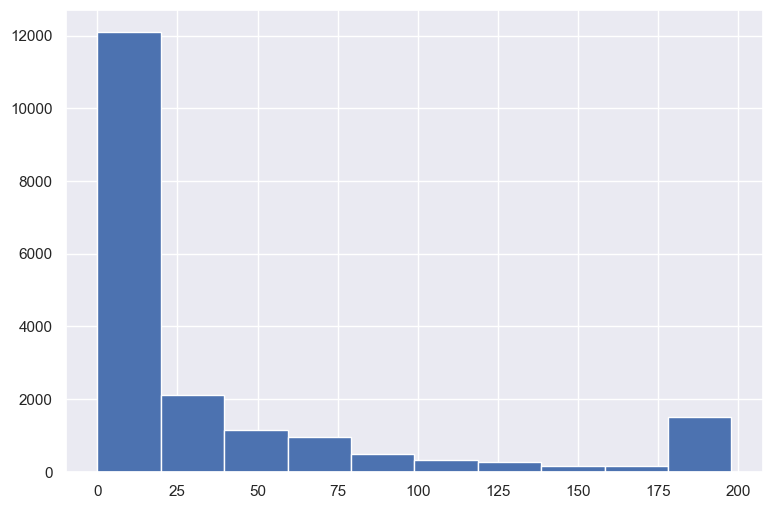

In [188]:
events_data.pivot_table(index='user_id', 
                        columns='action',  
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().discovered.hist()

In [189]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action',  
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

users_events_data.reset_index()

action,index,user_id,discovered,passed,started_attempt,viewed
0,0,1,1,0,0,1
1,1,2,9,9,2,10
2,2,3,91,87,30,192
3,3,5,11,11,4,12
4,4,7,1,1,0,1
...,...,...,...,...,...,...
19229,19229,26790,8,8,1,9
19230,19230,26793,1,0,1,1
19231,19231,26794,69,69,34,180
19232,19232,26797,10,10,2,13


Замечаем что данные стали полными

In [190]:
# начинаем работу с submissions_data
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [191]:
users_scores = submissions_data.pivot_table(index='user_id', 
                                        columns='submission_status',  
                                        values='step_id', 
                                        aggfunc='count', 
                                        fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


**Задача**: определить сколько людей ушло

In [192]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id',  'day']) \
  .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [193]:
gap_data_frame = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id',  'day']) \
  .groupby('user_id')['timestamp'].apply(list) \
  .apply(np.diff)
# сколько времени прошло между разными наблюдениями 
# np.diff([1, 2, 5]) => array([1, 3]) (2-1=1, 5-2=3)

gap_data = gap_data_frame.values
gap_data_frame.head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [194]:
gap_data_list = np.concatenate(gap_data, axis=0)
gap_data_list

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990],
      shape=(97872,))

In [195]:
gap_data = pd.Series(gap_data_list)
gap_data = gap_data / (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

<Axes: >

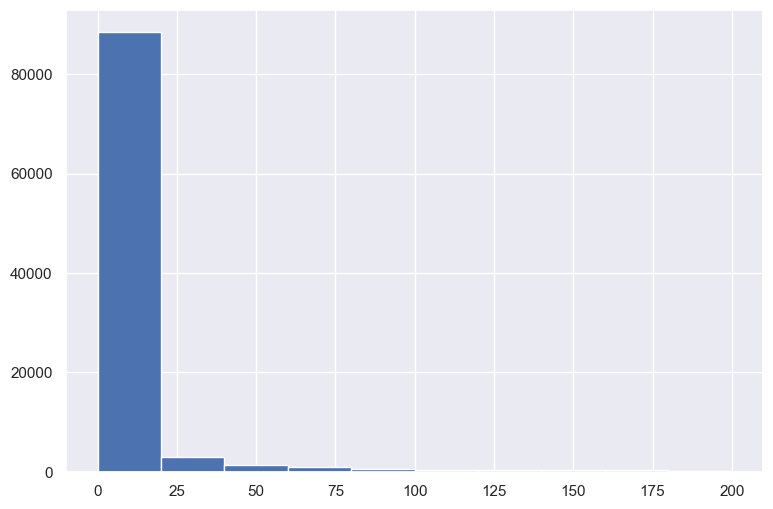

In [196]:
gap_data[gap_data < 200].hist()

In [197]:
gap_data.quantile(0.95)
# только 5% возвращаются на курс после перерыва в 2 месяца (59 дней)

np.float64(59.760440972222156)

**Задача**: определить, являются ли пользователи "пропавшими" (не появляется больше 30 дней). При этом необходимо учитывать, что если пользователь получил сертификат, он не считается пропавшим

In [198]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [199]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [200]:
now = 1526772811
drop_out_threshold = 30 * 24 * 60 * 60

users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [201]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [202]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
# outer чтобы не потерять данные
users_data = users_data.fillna(0)
users_data.head()

# 	True	0.0	0.0 - не было никаких событий, значит он "дропнулся"
# 	False	0.0	0.0 - не было никаких событий, но месяц еще не прошел


,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [203]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [204]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days.head()
# уникальный дни

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [205]:
users_days = users_data.merge(users_days, how='outer')
users_days.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [209]:
# проверка что не потеряли данные
users_data_count = users_data.user_id.nunique()
print(users_data_count)

users_data_scores_events_days_count = users_data_days.user_id.nunique()
print(users_data_scores_events_days_count)

19234
19234


In [212]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,False


In [211]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
passed_course,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [ ]:
100 * 1425 / 17809
# 8% прошли курсы

8.001572238755685